## Bike Index Seattle - Data Prep

### Data cleaning for Seattle streets data, Pt2

[Traffic Volume Data](https://data.seattle.gov/Transportation/Traffic-Flow-Map-Volumes/38vd-gytv)



[2016 Volume](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::2016-traffic-flow-counts/about)
[2016 Metadata](https://www.seattle.gov/Documents/Departments/SDOT/GIS/2016_Traffic_Flow_Counts_OD.pdf)

[2017 Volume](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::2017-traffic-flow-counts/about)
[2017 Metadata](https://drive.google.com/file/d/1GEuTEN-oPdtu5zesU1XJKubNt2RX2Lwj/view)

[2018 Volume](https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::2018-traffic-flow-counts/about)
[2018 Metadata](https://drive.google.com/file/d/1H-ooaihoawm8zXjZz_-AhBmwyRiT1FWQ/view)

Use 2018 Volume data as proxy-

- No data available for 2019-2020
    - Could take volume for location given year, but cannot compute for later periods
- Latest available volume data
- Earlier volume data (2016, 2017) has incomplete street segments

In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, LineString

import requests
import json

import matplotlib.pyplot as plt

from point_line_snap import SnapLinePoint

In [2]:
%matplotlib inline

In [3]:
# From Streets Prep

crashes_merged = pd.read_csv('data/crash_streets.csv', parse_dates=['DATETIME'])

In [4]:
# From Crash Data Prep

crashes = pd.read_csv('data/bike_crash.csv', parse_dates=['DATETIME'])

<AxesSubplot:xlabel='DATETIME'>

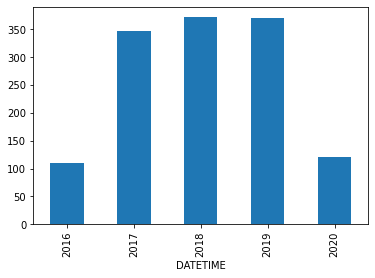

In [5]:
# Distribution of crashes by year- what vehicle volume data to use?

crashes_merged['line_i'].groupby(crashes_merged.DATETIME.dt.year).count().plot(kind='bar')

In [6]:
#url = 'https://data.seattle.gov/resource/38vd-gytv.json'

#r = requests.get(url)

In [6]:
# Helper function

def get_gdf(url):
    
    r = requests.get(url)
    json = r.json()
    
    return gpd.GeoDataFrame.from_features(json['features'])

In [7]:
# No volume data for 2019 or 2020 available as of Jul 2021

url_2016 = 'https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson'
url_2017 = 'https://opendata.arcgis.com/datasets/2c37babc94d64bbb938a9b520bc5538c_10.geojson'
url_2018 = 'https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.geojson'


In [8]:
vol_2016 = get_gdf(url_2016)
vol_2017 = get_gdf(url_2017)
vol_2018 = get_gdf(url_2018)

In [9]:
vol_2016.describe()

,OBJECTID,FLOWSEGID,COUNTAADT,COUNTAAWDT,AWDT_ROUND,SHAPE_Length
count,1865.000000,1864.000000,595.000000,1865.000000,1860.000000,1865.000000
mean,933.000000,1030.725858,12330.279216,12179.238152,12211.021505,1337.320872
std,538.523444,586.007948,10519.492108,9913.343071,9908.481814,1381.144172
min,1.000000,3.000000,0.000000,400.000000,600.000000,48.541264
25%,467.000000,538.750000,5614.759886,5500.000000,5500.000000,364.837266
50%,933.000000,1020.500000,9753.330064,9696.434239,9800.000000,835.403618
75%,1399.000000,1537.250000,16225.992849,16000.000000,16000.000000,1796.550094
max,1865.000000,4493.000000,102554.862657,108178.569998,108200.000000,13076.444950


In [10]:
vol_2016.columns

Index(['geometry', 'OBJECTID', 'COUNT_COMPKEY', 'FIRST_STNAME_ORD',
       'FIRST_ARTDESCRIPT', 'FIRST_TRANDESCRIPT', 'COUNTFLAG', 'FLOWSEGID',
       'DOWNTOWN', 'COUNTSTART', 'COUNTAADT', 'COUNTAAWDT', 'ESTIMATE',
       'AWDT_ROUND', 'SHAPE_Length'],
      dtype='object')

In [11]:
vol_2017.columns

Index(['geometry', 'OBJECTID', 'COMPKEY', 'STNAME_ORD', 'FLOWSEGID',
       'DOWNTOWN', 'START_DATE', 'AMPK', 'PMPK', 'AWDT', 'ADT', 'AWDT_ROUNDED',
       'DATAQUALITY', 'FLAGS', 'SHAPE_Length'],
      dtype='object')

In [12]:
vol_2018.columns

Index(['geometry', 'OBJECTID', 'COMPKEY', 'STNAME_ORD', 'FLOWSEGID',
       'DOWNTOWN', 'START_DATE', 'AMPK', 'PMPK', 'AWDT', 'ADT', 'AWDT_ROUNDED',
       'DATAQUALITY', 'FLAGS', 'SHAPE_Length'],
      dtype='object')

In [13]:
vol_2016 = vol_2016.rename(columns = {'COUNTAADT':'ADT_2016', 'COUNTAAWDT':'AWDT_2016'})

In [14]:
gdf = vol_2016.merge(vol_2017.rename(columns = {'ADT':'ADT_2017',
                                               'AWDT':'AWDT_2017'})[['FLOWSEGID',
                                                                     'geometry',
                                                                     'STNAME_ORD',
                                                                     'ADT_2017',
                                                                     'AWDT_2017']],
                    how='outer', on ='FLOWSEGID')

gdf = gdf.merge(vol_2018.rename(columns = {'ADT':'ADT_2018',
                                          'AWDT':'AWDT_2018'})[['FLOWSEGID', 
                                                                'geometry',
                                                                'STNAME_ORD',
                                                                'ADT_2018',
                                                                'AWDT_2018']],
               how='outer', on='FLOWSEGID')

In [15]:
gdf.columns

Index(['geometry_x', 'OBJECTID', 'COUNT_COMPKEY', 'FIRST_STNAME_ORD',
       'FIRST_ARTDESCRIPT', 'FIRST_TRANDESCRIPT', 'COUNTFLAG', 'FLOWSEGID',
       'DOWNTOWN', 'COUNTSTART', 'ADT_2016', 'AWDT_2016', 'ESTIMATE',
       'AWDT_ROUND', 'SHAPE_Length', 'geometry_y', 'STNAME_ORD_x', 'ADT_2017',
       'AWDT_2017', 'geometry', 'STNAME_ORD_y', 'ADT_2018', 'AWDT_2018'],
      dtype='object')

<AxesSubplot:>

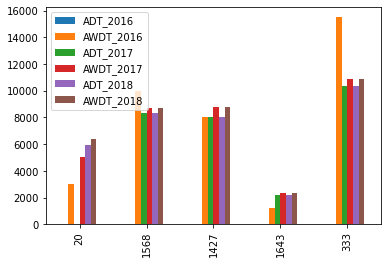

In [16]:
check_ix = np.random.randint(len(gdf)-1, size=5)

cols = ['ADT_2016','AWDT_2016','ADT_2017','AWDT_2017','ADT_2018','AWDT_2018']

gdf.iloc[check_ix][cols].plot(kind='bar')

In [17]:
for col in cols:
    print('col: ', col, gdf[col].isna().sum())

col:  ADT_2016 1341
col:  AWDT_2016 71
col:  ADT_2017 943
col:  AWDT_2017 53
col:  ADT_2018 506
col:  AWDT_2018 25


In [18]:
adt_cols = ['ADT_2016','ADT_2017','ADT_2018']
awdt_cols = ['AWDT_2016','AWDT_2017','AWDT_2018']

In [19]:
np.mean(gdf[adt_cols], axis=1)

0        5508.944333
1       27080.945000
2           0.000000
3        3622.894667
4       46875.028445
            ...     
1931      718.000000
1932     1406.000000
1933      902.000000
1934     1915.000000
1935     7779.000000
Length: 1936, dtype: float64

In [20]:
np.mean(gdf[awdt_cols], axis=1)

0        6829.834667
1       28793.130667
2       23393.888000
3        4421.975667
4       50036.009802
            ...     
1931      917.000000
1932     1453.000000
1933      960.000000
1934     1743.000000
1935     7870.000000
Length: 1936, dtype: float64

In [21]:
adt_mean = np.nanmean(gdf[adt_cols], axis=1)

<ipython-input-21-f02cd58b0b73>:1: RuntimeWarning: Mean of empty slice
  adt_mean = np.nanmean(gdf[adt_cols], axis=1)


In [22]:
awdt_mean = np.nanmean(gdf[awdt_cols], axis=1)

In [23]:
gdf['adt_mean'] = adt_mean
gdf['awdt_mean'] = awdt_mean

In [24]:
# Use 2018 as proxy for all crashes
# No data available for 2019, 2020
# 2018 is more complete than 2017 or 2016


volume = vol_2018

In [25]:
volume.columns

Index(['geometry', 'OBJECTID', 'COMPKEY', 'STNAME_ORD', 'FLOWSEGID',
       'DOWNTOWN', 'START_DATE', 'AMPK', 'PMPK', 'AWDT', 'ADT', 'AWDT_ROUNDED',
       'DATAQUALITY', 'FLAGS', 'SHAPE_Length'],
      dtype='object')

In [26]:
keep_cols = ['geometry',
            'STNAME_ORD',
            'AWDT',
            'ADT',
            'AWDT_ROUNDED',
            'SHAPE_Length']

vol_gdf = gpd.GeoDataFrame(volume[keep_cols], geometry='geometry')

In [27]:
geom = [Point(xy) for xy in zip(crashes.LONGITUDE, crashes.LATITUDE)]

crashes_gdf = gpd.GeoDataFrame(crashes.drop(['LATITUDE','LONGITUDE'], axis = 1),
                               geometry = geom)

In [28]:
vol_gdf.head()

,geometry,STNAME_ORD,AWDT,ADT,AWDT_ROUNDED,SHAPE_Length
0,"LINESTRING (-122.33315 47.61306, -122.33204 47...",PINE ST,8000.0,NaN,8000,322.037238
1,"LINESTRING (-122.37523 47.65358, -122.37539 47...",15TH AVE W ON RP,11129.0,10139.0,11100,173.612269
2,"MULTILINESTRING ((-122.30381 47.67578, -122.30...",NE 65TH ST,20487.0,19740.0,20500,1445.416389
3,"MULTILINESTRING ((-122.41212 47.65410, -122.41...",W EMERSON ST,1007.0,1090.0,1000,999.190937
4,"MULTILINESTRING ((-122.28080 47.52610, -122.28...",S CLOVERDALE ST,4868.0,4615.0,4900,2077.434844


In [29]:
offset = 10**-4

slp = SnapLinePoint(crashes_gdf, vol_gdf, offset)

In [30]:
vol_merged = slp.snap_to_line()

In [31]:
vol_merged.columns

Index(['line_i', 'line_geo', 'STNAME_ORD', 'AWDT', 'ADT', 'AWDT_ROUNDED',
       'SHAPE_Length', 'REPORT NUMBER', 'PRIMARY TRAFFICWAY',
       'INTERSECTING TRAFFICWAY', 'DATETIME', 'is_dry', 'is_light', 'is_clear',
       'is_hit_run', 'is_workzone', 'is_child', 'impaired', 'speeding',
       'driver_16_25', 'driver_65_plus', 'severity', 'point', 'snap_dist',
       'geometry'],
      dtype='object')

In [37]:
crashes_merged['REPORT NUMBER'].shape

(1320,)

In [38]:
vol_merged.shape

(1169, 25)

In [42]:
vol_merged.columns

Index(['line_i', 'line_geo', 'STNAME_ORD', 'AWDT', 'ADT', 'AWDT_ROUNDED',
       'SHAPE_Length', 'REPORT NUMBER', 'PRIMARY TRAFFICWAY',
       'INTERSECTING TRAFFICWAY', 'DATETIME', 'is_dry', 'is_light', 'is_clear',
       'is_hit_run', 'is_workzone', 'is_child', 'impaired', 'speeding',
       'driver_16_25', 'driver_65_plus', 'severity', 'point', 'snap_dist',
       'geometry'],
      dtype='object')

In [46]:
select_cols = ['AWDT','ADT','AWDT_ROUNDED','REPORT NUMBER','vol_geo']

vol_select = vol_merged.rename(columns={'line_geo':'vol_geo'})[select_cols]

In [47]:
gdf = vol_select.merge(crashes_merged, on='REPORT NUMBER')

In [48]:
gdf.head()

,AWDT,ADT,AWDT_ROUNDED,REPORT NUMBER,vol_geo,line_i,DATETIME,geometry,line_geo,SPEEDLIMIT,...,is_light,is_clear,is_hit_run,is_workzone,is_child,impaired,speeding,driver_16_25,driver_65_plus,severity
0,6551.0,6058.0,6700,3773772,"MULTILINESTRING ((-122.31811 47.60621, -122.31...",5040.0,2019-04-19 15:52:00,POINT (-122.3194157932671 47.60620717409615),"LINESTRING (-122.3194130473 47.60520171290543,...",20.0,...,1,0,0,0,0,0,0,0,0,3
1,11001.0,10581.0,11300,3773784,"MULTILINESTRING ((-122.32023 47.62546, -122.32...",5053.0,2017-06-27 06:40:00,POINT (-122.320220950092 47.62656256721589),LINESTRING (-122.320226408124 47.6254609770248...,25.0,...,1,0,0,0,0,0,0,0,0,3
2,18147.0,16962.0,18100,E779051,"MULTILINESTRING ((-122.32007 47.63840, -122.32...",22.0,2018-03-10 23:00:00,POINT (-122.3200693522767 47.63866711037208),LINESTRING (-122.3200712955947 47.638403224769...,25.0,...,0,0,1,0,0,0,0,0,0,3
3,13771.0,12966.0,13800,3773767,"MULTILINESTRING ((-122.32021 47.62867, -122.32...",21776.0,2017-07-02 15:13:00,POINT (-122.3200853721749 47.6364851511106),LINESTRING (-122.3200894771424 47.635912816973...,25.0,...,1,0,0,0,0,0,0,0,0,3
4,13771.0,12966.0,13800,3814426,"MULTILINESTRING ((-122.32021 47.62867, -122.32...",14741.0,2018-10-23 21:24:00,POINT (-122.3200713729534 47.63839277947622),LINESTRING (-122.3200798231693 47.637251797263...,25.0,...,0,0,0,0,0,0,0,0,0,2


In [49]:
gdf.columns

Index(['AWDT', 'ADT', 'AWDT_ROUNDED', 'REPORT NUMBER', 'vol_geo', 'line_i',
       'DATETIME', 'geometry', 'line_geo', 'SPEEDLIMIT', 'SURFACEWIDTH',
       'one_way', 'is_steep', 'is_paved', 'is_hwy', 'is_bus', 'is_truck',
       'is_light', 'is_clear', 'is_hit_run', 'is_workzone', 'is_child',
       'impaired', 'speeding', 'driver_16_25', 'driver_65_plus', 'severity'],
      dtype='object')

In [ ]:
gdf.

In [51]:
gdf.to_csv('data/crash_streets_vol.csv', index=False)